Rows: 802 | duplicate keys: 0 | rows missing XYZ: 0


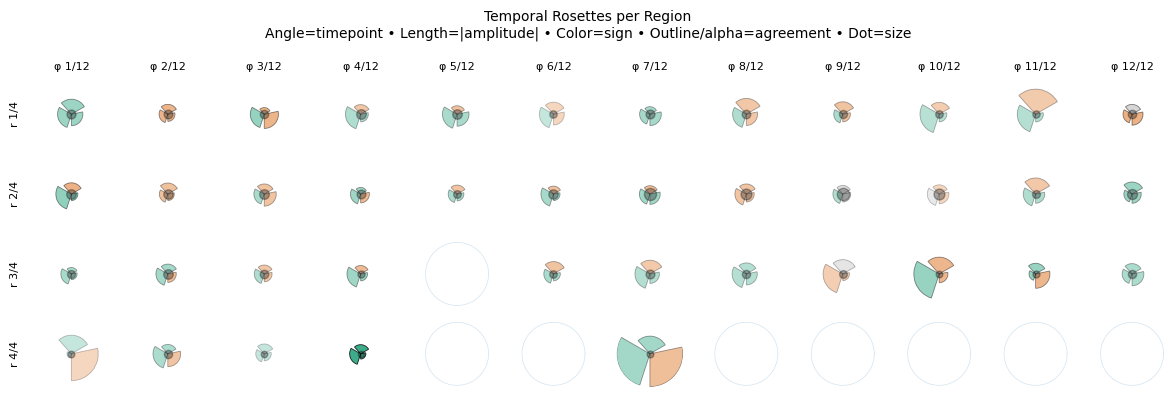

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

coord_cols = ("middle_x", "middle_y", "middle_z")

# 3 timepoints (12h, 18h, 24h) for expression + accessibility
feature_cols = {
    "expr": ["expr_delta_12h", "expr_delta_18h", "expr_delta_24h"],
    "acc":  ["acc_delta_12h_tss", "acc_delta_18h_tss", "acc_delta_24h_tss"],
}
time_labels = ["12h", "18h", "24h"]  # must match ordering above
n_r, n_phi = 4, 12                   # radial bands × angular wedges
min_genes_per_zone = 5               # skip very sparse cells

# Colors for sign 
COLOR_POS = "#d95f02"  # warm for up
COLOR_NEG = "#1b9e77"  # cool for down
COLOR_ZERO = "#aaaaaa"

# Geometry helpers 
def _unit(v):
    v = np.asarray(v, float); n = np.linalg.norm(v)
    return v / (n + 1e-12)

def rotation_matrix_from_vectors(a, b):
    """Rotate vector a onto vector b (both 3d)."""
    a, b = _unit(a), _unit(b)
    v = np.cross(a, b)
    c = np.dot(a, b)
    if np.allclose(v, 0) and c > 0:  # already aligned
        return np.eye(3)
    if np.allclose(v, 0) and c < 0:  # opposite
        # 180°: rotate around any axis orthogonal to a
        orth = _unit(np.array([1,0,0]) if abs(a[0]) < 0.9 else np.array([0,1,0]))
        v = _unit(np.cross(a, orth))
        H = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
        return -np.eye(3) + 2*np.outer(v, v)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])
    return np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s**2 + 1e-12))

def pca_axis(points):
    P = points - points.mean(axis=0, keepdims=True)
    # top singular vector
    u, s, vh = np.linalg.svd(P, full_matrices=False)
    return vh[0]  # principal direction

def cylindrical_bins(points, n_r, n_phi):
    """Rotate to align 1st PC to +Z, then cylindrical (r, phi)."""
    center = points.mean(axis=0)
    P = points - center
    axis = pca_axis(points)
    R = rotation_matrix_from_vectors(axis, np.array([0,0,1.0]))
    Prot = (R @ P.T).T
    x, y, z = Prot[:,0], Prot[:,1], Prot[:,2]
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)  # [-pi, pi)
    r_norm = r / (r.max() + 1e-12)
    r_edges = np.linspace(0, 1, n_r + 1)
    phi_edges = np.linspace(-np.pi, np.pi, n_phi + 1)
    r_ids = np.digitize(r_norm, r_edges) - 1
    phi_ids = np.digitize(phi, phi_edges) - 1
    # clamp
    r_ids = np.clip(r_ids, 0, n_r - 1)
    phi_ids = np.clip(phi_ids, 0, n_phi - 1)
    return r_ids, phi_ids, r_edges, phi_edges

# Zone stats 
def compute_zone_stats(df, coord_cols, feature_cols, n_r, n_phi, min_genes=1):
    pts = df[list(coord_cols)].to_numpy(float)
    r_ids, phi_ids, r_edges, phi_edges = cylindrical_bins(pts, n_r, n_phi)

    # Gather available per-timepoint arrays per feature
    features = list(feature_cols.keys())
    K = len(next(iter(feature_cols.values())))
    # ensure all lists have K entries
    assert all(len(cols)==K for cols in feature_cols.values())

    zone = {
        "r": [], "phi": [], "N": [],
        "A": [],                 # amplitudes (length K)
        "S": [],                 # signs (length K)
        "peak_idx": [],          # int in [0..K-1]
        "agreement": []          # 0..1 (np.nan if undefined)
    }

    # Pre-extract arrays for speed
    feat_arrays = {
        f: [df[c].to_numpy(float) if c in df else np.full(len(df), np.nan)
            for c in cols]
        for f, cols in feature_cols.items()
    }

    # For agreement, build per-gene vectors by averaging across features
    per_gene = np.full((len(df), K), np.nan)
    for t in range(K):
        stacks = []
        for f in features:
            stacks.append(feat_arrays[f][t])
        M = np.vstack(stacks)  # F × N
        per_gene[:, t] = np.nanmean(M, axis=0)

    for ri in range(n_r):
        for pj in range(n_phi):
            idx = np.where((r_ids == ri) & (phi_ids == pj))[0]
            N = len(idx)
            zone["r"].append(ri); zone["phi"].append(pj); zone["N"].append(N)

            if N < min_genes:
                zone["A"].append([np.nan]*K)
                zone["S"].append([0]*K)
                zone["peak_idx"].append(np.nan)
                zone["agreement"].append(np.nan)
                continue

            # Amplitude & sign at each time (aggregate all gene-feature values)
            A = []
            S = []
            for t in range(K):
                vals_t = []
                for f in features:
                    arr = feat_arrays[f][t][idx]
                    if arr.size:
                        vals_t.append(arr)
                if len(vals_t) == 0:
                    A.append(np.nan); S.append(0)
                else:
                    vals_t = np.concatenate(vals_t)
                    med = np.nanmedian(vals_t)
                    A.append(np.nanmedian(np.abs(vals_t)))
                    S.append(0 if np.isnan(med) or abs(med) < 1e-12 else (1 if med > 0 else -1))

            A = np.array(A, float)
            # Peak index among finite amplitudes
            if np.all(~np.isfinite(A)) or np.nanmax(A) <= 0:
                peak_idx = np.nan
            else:
                peak_idx = int(np.nanargmax(A))
            zone["A"].append(A.tolist())
            zone["S"].append(S)
            zone["peak_idx"].append(peak_idx)

            # Agreement across genes
            if np.isnan(peak_idx):
                zone["agreement"].append(np.nan)
            else:
                gmat = per_gene[idx, :]  # N_zone × K
                valid_rows = ~np.all(~np.isfinite(gmat), axis=1)
                gmat = gmat[valid_rows]
                if gmat.shape[0] == 0:
                    zone["agreement"].append(np.nan)
                else:
                    # per-gene peak + sign
                    peaks = np.nanargmax(np.abs(gmat), axis=1)
                    signs = np.sign(gmat[np.arange(len(gmat)), peaks])
                    agree = np.mean((peaks == peak_idx) & (signs == S[peak_idx]))
                    zone["agreement"].append(float(agree))

    zone_df = pd.DataFrame(zone)
    return zone_df

# Drawing
def draw_rosette_grid(zone_df, n_r, n_phi, time_labels, save_path=None):
    # Find global amplitude max for radius normalization
    all_A = np.concatenate([np.array(a, float) for a in zone_df["A"].values if isinstance(a, list)])
    Amax = np.nanmax(all_A) if np.any(np.isfinite(all_A)) else 1.0
    K = len(time_labels)
    thetas = (2*np.pi * np.arange(K) / K) - (np.pi/2)  # 0=top
    width = 2*np.pi / K * 0.85

    fig, axs = plt.subplots(n_r, n_phi, subplot_kw={"projection": "polar"},
                            figsize=(n_phi*1.0, n_r*1.0), squeeze=False)
    for _, row in zone_df.iterrows():
        ri, pj = int(row["r"]), int(row["phi"])
        ax = axs[ri, pj]
        ax.set_xticks([]); ax.set_yticks([]); ax.set_rlim(0, 1.0)
        ax.grid(False); ax.spines["polar"].set_visible(False)

        A = np.array(row["A"], float)
        if not isinstance(row["A"], list) or not np.any(np.isfinite(A)):
            # empty/sparse zone → faint ring
            ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*0.95, lw=0.5, alpha=0.2)
            continue

        S = row["S"]; peak_idx = row["peak_idx"]; agree = row["agreement"]
        agree_alpha = 0.25 + 0.6 * (0 if np.isnan(agree) else np.clip(agree, 0, 1))
        # draw petals
        for t in range(K):
            radius = 0 if not np.isfinite(A[t]) or Amax <= 0 else np.clip(A[t]/Amax, 0, 1)
            color = COLOR_ZERO if S[t] == 0 else (COLOR_POS if S[t] > 0 else COLOR_NEG)
            lw = 1.5 if (isinstance(peak_idx, (int, np.integer)) and t == peak_idx) else 0.6
            bars = ax.bar([thetas[t]], [radius], width=width, bottom=0.0,
                          align="edge", color=color, edgecolor="black",
                          linewidth=lw, alpha=agree_alpha)
        # center dot scales with N
        N = row["N"]; Nmax = max(1, int(zone_df["N"].max()))
        ax.scatter([0], [0], s=20 + 60*(N/Nmax), c="black", alpha=0.3)

    # row/col labels (optional)
    for pj in range(n_phi):
        axs[0, pj].set_title(f"φ {pj+1}/{n_phi}", fontsize=8, pad=8)
    for ri in range(n_r):
        axs[ri, 0].text(-0.35, 0.5, f"r {ri+1}/{n_r}", transform=axs[ri, 0].transAxes,
                        rotation=90, va="center", ha="center", fontsize=8)

    # legend-like stripe
    fig.suptitle("Temporal Rosettes per Region\nAngle=timepoint • Length=|amplitude| • Color=sign • Outline/alpha=agreement • Dot=size", fontsize=10)
    if save_path:
        fig.tight_layout()
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
    return fig, axs


# Inputs
deltas_csv = "data/green_monkey/all_structure_files/chr1/temporal_data/chr1_temporal_trendCategories_valuePattern.csv"   
xyz_csv    = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"  

# Columns/config
key_col = "gene_name"
xyz_cols = [key_col, "middle_x", "middle_y", "middle_z"]

# Load 
df_delta = pd.read_csv(deltas_csv)
df_xyz   = pd.read_csv(xyz_csv)[xyz_cols]

# Merge (inner join keeps only genes present in both)
merged_df = pd.merge(df_delta, df_xyz, on=key_col, how="inner")

# Sanity checks 
dup_keys = merged_df[key_col].duplicated().sum()
missing_positions = merged_df[["middle_x","middle_y","middle_z"]].isna().any(axis=1).sum()
print(f"Rows: {len(merged_df)} | duplicate keys: {dup_keys} | rows missing XYZ: {missing_positions}")

# pass merged_df to the rosette pipeline:
zone_df = compute_zone_stats(merged_df, ("middle_x","middle_y","middle_z"), feature_cols, n_r, n_phi)
fig, axs = draw_rosette_grid(zone_df, n_r, n_phi, time_labels, save_path="data/green_monkey/va_testing/rosettes_grid.png")
# zone_df.to_csv("rosette_zone_stats.csv", index=False)